# Preparations

## Imports

In [74]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from cot.models.transformer import Transformer, TransformerConfig
import seaborn as sns
from typing import List
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import trange
from copy import deepcopy
import math

## Hyper-params

In [75]:
import sys

sys.set_int_max_str_digits(100000)

In [76]:
epochs = 10
batch_size = 64
min_len = 4
max_len = 10
total_runs = 10
SEQ_LEN=160
SAMPLES_SIZE=8192

config = TransformerConfig(
    vocab_size=12,
    emb_dim=128,
    n_head=1,
    seq_len=SEQ_LEN,
    n_layer=2,
    norm="layer",
    norm_bias=True,
    weight_tying=True,
)


## Datasets

### Polynomial Dataset

In [77]:
class PolyDataset(torch.utils.data.Dataset):
    def __init__(self, p=11):
        self.p = p
        self.samples = []
        for _ in range(SAMPLES_SIZE):
            x = torch.randint(0, p, (random.randint(2, SEQ_LEN),))
            y = (x[0] * x[1] + 1) % p
            target = torch.full((x.size(0),), p, dtype=torch.long)  # label marker
            target[-1] = y
            self.samples.append((x, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


### Parity Dataset

In [78]:
class ParityDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.samples = []
        for _ in range(SAMPLES_SIZE):
            length = np.random.randint(2, SEQ_LEN + 1)
            bits = np.random.randint(0, 2, size=length)
            parity = np.cumsum(bits) % 2
            self.samples.append((bits, parity))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)


### Factorial Dataset

In [100]:
import math
import torch
from torch.utils.data import Dataset

def strip_trailing_zeros(arr):
    i = len(arr)
    while i > 0 and arr[i-1] == 0:
        i -= 1
    zero_count = len(arr[i:])
    return arr[:i], [int(d) for d in str(zero_count)]

class FactorialDataset(Dataset):
    def __init__(self, size=SAMPLES_SIZE):
        self.data = []
        self.labels = []

        max_n = SAMPLES_SIZE * 2 + 1  
        for _ in range(size):
            n = torch.randint(3, max_n, (1,)).item()
            # input = single number n, represented as digits padded to seq_len
            x_digits = [int(d) for d in str(n)]
            x_digits = [0]*(SEQ_LEN - len(x_digits)) + x_digits  # left pad

            # output = factorial(n), also padded/truncated to seq_len
            fact = math.factorial(n)
            y_digits = [int(d) for d in str(fact)]
            y_head, y_tail = strip_trailing_zeros(y_digits)
            y_digits = y_head + [10] + y_tail
            if len(y_digits) > SEQ_LEN:
                y_digits = y_digits[-SEQ_LEN:]  # keep last seq_len digits
            else:
                y_digits = [0]*(SEQ_LEN - len(y_digits)) + y_digits

            self.data.append(torch.tensor(x_digits, dtype=torch.long))
            self.labels.append(torch.tensor(y_digits, dtype=torch.long))

        self.data = torch.stack(self.data)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


### Fibonacci Dataset

In [80]:
import torch
from torch.utils.data import Dataset

class FibonacciDataset(Dataset):
    def __init__(self, size=1000, seq_len=160):
        self.seq_len = seq_len
        self.samples = []

        # Precompute Fibonacci numbers as strings to avoid overflow
        fib_cache = {0: "0", 1: "1"}
        def fib_str(n):
            if n in fib_cache:
                return fib_cache[n]
            a, b = "0", "1"
            for _ in range(2, n+1):
                a, b = b, str(int(a) + int(b))
            fib_cache[n] = b
            return b

        for _ in range(size):
            n = torch.randint(0, SAMPLES_SIZE * 2 + 1, (1,)).item()
            
            # Input as digits
            x_digits = [int(d) for d in str(n)]
            x_digits = [0]*(seq_len - len(x_digits)) + x_digits
            input_seq = torch.tensor(x_digits, dtype=torch.long)

            # Fibonacci as digits
            y_str = fib_str(n)
            y_digits = [int(d) for d in y_str]
            if len(y_digits) > seq_len:
                y_digits = y_digits[-seq_len:]  # keep last seq_len digits
            else:
                y_digits = [0]*(seq_len - len(y_digits)) + y_digits
            target_seq = torch.tensor(y_digits, dtype=torch.long)

            self.samples.append((input_seq, target_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


### Padding method

In [81]:
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = pad_sequence(xs, batch_first=True, padding_value=0)
    ys = pad_sequence(ys, batch_first=True, padding_value=0)
    return xs, ys

## Model Object

In [82]:
class Trainer:
    all_accuracies = []

    def __init__(self, config, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.config = config
        self.model = Transformer(config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.task_counter = {}  
        self.accuracies = []
        self.static_index = len(Trainer.all_accuracies)   
        Trainer.all_accuracies.append([])

    def reset_optimizer(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def __get_dataset__ (self, task):
        if task == 'polynomial':
            return PolyDataset()
        elif task == 'parity':
            return ParityDataset()
        elif task == 'factorial':
            return FactorialDataset()
        elif task == 'fibonacci':
            return FibonacciDataset()
        else:
            raise ValueError("Unknown task")

    def train(self, task='polynomial', epochs=10):
        dataset = self.__get_dataset__(task)
        count = self.task_counter.get(task, 0) + 1
        self.task_counter[task] = count
        task_name = f"{task} {count}"

        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)
        accs = []

        pbar = trange(epochs)
        for epoch in pbar:
            self.model.train()
            total_loss = 0
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(x)
                loss = self.criterion(logits.view(-1, logits.size(-1)), y.view(-1))
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            acc = self.evaluate(loader, verbose=False)
            accs.append(acc)
            avg_loss = total_loss / len(loader)
            pbar.set_description(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Acc: {acc:.2%}")

        self.accuracies.append({
            "name": task_name,
            "accs": accs
        })
        
        Trainer.all_accuracies[self.static_index] = [a for entry in self.accuracies for a in entry["accs"]]

    def evaluate(self, loader, verbose=True):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                preds = torch.argmax(logits, dim=-1)
                correct += (preds == y).sum().item()
                total += y.numel()
        acc = correct / total
        if verbose:
            print(f"Accuracy: {acc:.2%}")

        return acc

    def plot_accuracy(self):
        if not self.accuracies:
            print("No runs to plot.")
            return

        start_x = 0
        for entry in self.accuracies:
            name = entry["name"]
            accs = entry["accs"]
            x = list(range(start_x, start_x + len(accs)))
            plt.plot(x, accs, label=name)
            start_x += len(accs)
    
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.legend()
        plt.grid()
        plt.show()

    def fork(self):
        new_trainer = Trainer(self.config, batch_size=self.batch_size)
        new_trainer.model.load_state_dict(deepcopy(self.model.state_dict()))
        new_trainer.optimizer.load_state_dict(deepcopy(self.optimizer.state_dict()))
        new_trainer.criterion = deepcopy(self.criterion)
        new_trainer.task_counter = deepcopy(self.task_counter)
        new_trainer.accuracies = deepcopy(self.accuracies)

        Trainer.all_accuracies[new_trainer.static_index] = deepcopy(
            Trainer.all_accuracies[self.static_index]
        )

        return new_trainer


    @staticmethod
    def summarize_runs():
        valid_runs = [a for a in Trainer.all_accuracies if a]

        if not valid_runs:
            print("No valid runs to summarize.")
            return

        max_len = max(len(a) for a in valid_runs)
        padded = [a + [a[-1]] * (max_len - len(a)) for a in valid_runs]
        mean_acc = np.mean(padded, axis=0)
        std_acc = np.std(padded, axis=0)

        plt.plot(mean_acc, label="Mean Accuracy")
        plt.fill_between(range(max_len), mean_acc - std_acc, mean_acc + std_acc, alpha=0.3, label="±1 std")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Average Accuracy Over Runs")
        plt.legend()
        plt.grid(True)
        plt.show()

# Replication

## Train

In [83]:
poly_trainer = Trainer(config)

### Polynomial training

In [84]:
poly_trainer.train(task='polynomial', epochs=200)

Epoch 199 | Loss: 0.0047 | Acc: 99.86%: 100%|██████████| 200/200 [1:23:02<00:00, 24.91s/it]


Accuracy: 97.28%


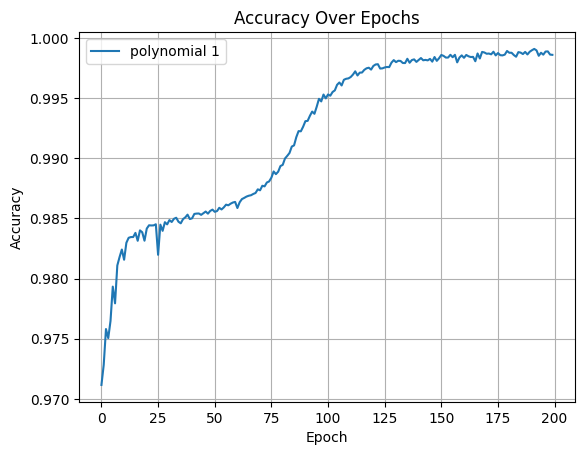

In [85]:
poly_loader = DataLoader(PolyDataset())
poly_trainer.evaluate(poly_loader)
poly_trainer.plot_accuracy()

### Parity training

In [86]:
parity_trainer = poly_trainer.fork()
parity_trainer.reset_optimizer()
parity_trainer.train(task='parity', epochs=50)

Epoch 49 | Loss: 0.3013 | Acc: 80.53%: 100%|██████████| 50/50 [20:56<00:00, 25.13s/it]


In [87]:
parity_loader = DataLoader(ParityDataset())
parity_trainer.evaluate(parity_loader)

Accuracy: 60.39%


0.6039202997787777

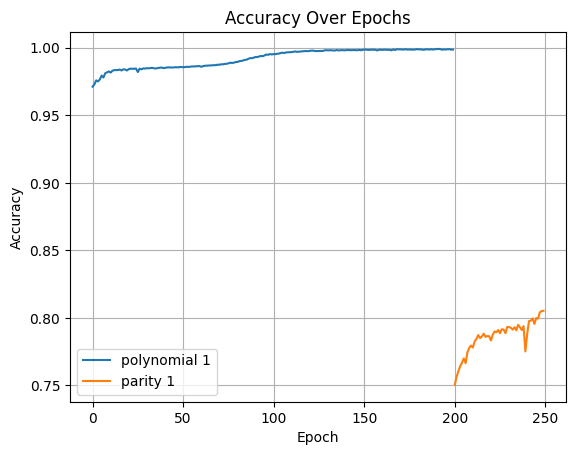

In [88]:
parity_trainer.plot_accuracy()

# Advanced Datasets to test

## Factorial training

In [105]:
factorial_trainer = Trainer(config) #poly_trainer.fork()
#factorial_trainer.reset_optimizer()
factorial_trainer.train(task='factorial', epochs=250)

Epoch 249 | Loss: 2.2355 | Acc: 13.14%: 100%|██████████| 250/250 [1:44:58<00:00, 25.19s/it]


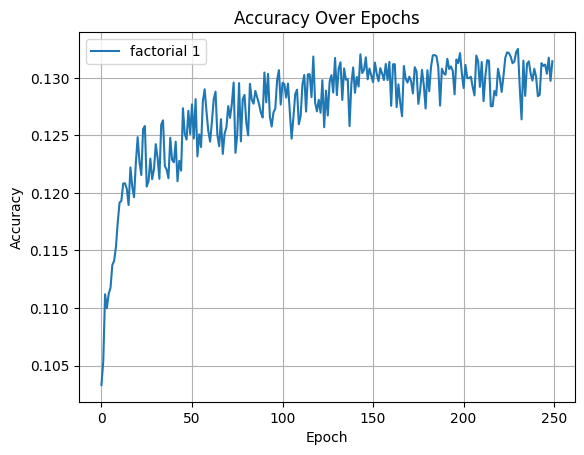

In [106]:
factorial_trainer.plot_accuracy()

## Fibonacci training

In [91]:
fibonacci_trainer = poly_trainer.fork()
fibonacci_trainer.reset_optimizer()
fibonacci_trainer.train(task='fibonacci', epochs=50)

Epoch 49 | Loss: 2.3001 | Acc: 12.32%: 100%|██████████| 50/50 [02:35<00:00,  3.12s/it]


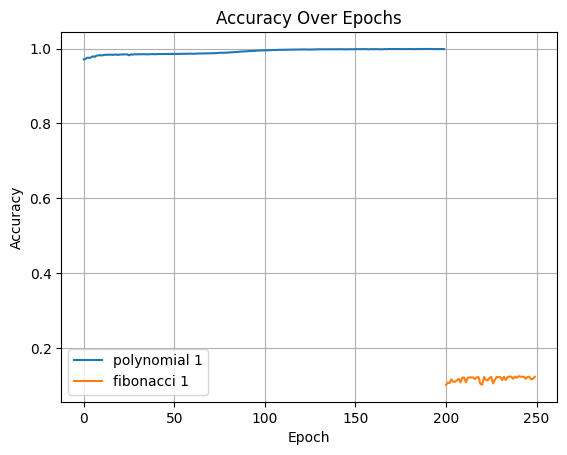

In [92]:
fibonacci_trainer.plot_accuracy()

# Multi-runs

In [93]:
#for _ in range(total_runs):
#    trainer = Trainer(config)
#    trainer.train(task='polynomial', epochs=200)
#    trainer.reset_optimizer()
#    trainer.train(task='parity', epochs=50)

# After several trainers
#Trainer.summarize_runs()


In [ ]:
fds = FibonacciDataset()
fds2 = [fds.__getitem__(i) for i in range(50)]
print(fds2)

In [101]:
ds = FactorialDataset(size=30)
ds2 = [ds.__getitem__(i) for i in range(30)]
print(ds2)

[(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 